In [1]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.6 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=6f20852256997c3dc77ce3c397d39c331569eef47d30533302c90141572cf5c0
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninsta

Vì hồi quy softmax rất cơ bản nên chúng tôi tin rằng bạn nên biết cách tự triển khai nó. Ở đây, chúng tôi giới hạn bản thân trong việc xác định các khía cạnh dành riêng cho softmax của mô hình và sử dụng lại các thành phần khác từ phần hồi quy tuyến tính của chúng tôi, bao gồm cả vòng huấn luyện.

In [2]:
import torch
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 4.4.1. Softmax

Hãy bắt đầu với phần quan trọng nhất: ánh xạ từ vô hướng sang xác suất. Để ôn lại, hãy nhớ lại hoạt động của toán tử tổng theo các thứ nguyên cụ thể trong một tenxơ, như đã thảo luận trong Phần 2.3.6 và Phần 2.3.7 . Cho trước một ma trận, Xchúng ta có thể tính tổng trên tất cả các phần tử (theo mặc định) hoặc chỉ trên các phần tử trong cùng một trục. Biến axischo phép chúng ta tính tổng hàng và cột:

In [3]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0 , 6.0]])
X.sum(0, keepdims = True), X.sum(1, keepdims = True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

Việc tính toán sofmax yêu cầu 3 bước:
- Lũy thừa từng số hạng
- Tổng trên mỗi hàng để tính hằng số chuẩn hóa cho từng ví dụ
- Chia mỗi hàng cho hằng số chuẩn hóa của nó, đảm bảo rằng kết quả có tổng bằng 1.
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$

Mẫu số (logarit của) được gọi là hàm phân hoạch (log) . Nó được giới thiệu trong vật lý thống kê để tổng hợp tất cả các trạng thái có thể có trong một quần thể nhiệt động lực học. Việc thực hiện rất đơn giản:

In [4]:
def softmax(X):  # triển khai hàm softmax theo công thức trên
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdims = True)
  return X_exp / partition

Đối với bất kỳ đầu vào nào X, chúng ta biến từng phần tử thành một số không âm. Mỗi hàng có tổng bằng 1, như yêu cầu đối với một xác suất. Chú ý: mã ở trên không mạnh đối với các đối số rất lớn hoặc rất nhỏ. Mặc dù điều này đủ để minh họa những gì đang xảy ra, nhưng bạn không nên sử dụng nguyên văn mã này cho bất kỳ mục đích nghiêm túc nào. Các khung học sâu có tích hợp các biện pháp bảo vệ như vậy và chúng tôi sẽ sử dụng softmax tích hợp sẵn trong tương lai.

In [5]:
"""Test hàm softmax"""
X = torch.rand((2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[0.8045, 0.7828, 0.1958, 0.9821, 0.1606],
         [0.9976, 0.2400, 0.7197, 0.2196, 0.3764]]),
 tensor([[0.2357, 0.2307, 0.1283, 0.2815, 0.1238],
         [0.3103, 0.1455, 0.2350, 0.1425, 0.1667]]),
 tensor([1., 1.]))

# 4.4.2. Model

Bây giờ chúng ta có mọi thứ cần thiết để triển khai mô hình hồi quy softmax. Như trong ví dụ hồi quy tuyến tính của chúng tôi, mỗi trường hợp sẽ được biểu thị bằng một vectơ có độ dài cố định. Vì dữ liệu thô ở đây bao gồm $28*28$
hình ảnh pixel, chúng tôi làm phẳng từng hình ảnh, coi chúng là vectơ có độ dài 784. Trong các chương sau, chúng tôi sẽ giới thiệu các mạng thần kinh tích chập, khai thác cấu trúc không gian theo cách thỏa mãn hơn.

Trong hồi quy softmax, số lượng đầu ra từ mạng của chúng tôi phải bằng số lượng lớp. Vì tập dữ liệu của chúng tôi có 10 lớp nên mạng của chúng tôi có kích thước đầu ra là 10. Do đó, các trọng số của chúng tôi tạo thành một $784*10$
ma trận cộng với một $1*10$ vectơ hàng chiều cho các bias. Như với hồi quy tuyến tính, chúng tôi khởi tạo các trọng số W bằng nhiễu Gaussian. Các bias ​​​​được khởi tạo là số không.

In [6]:
"""
Tạo một class SoftmaxRegressionScratch làm model
"""
class SoftmaxRegressionScratch(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, lr, sigma = 0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W = torch.normal(mean = 0,
                          std = sigma,
                          size = (num_inputs, num_outputs),
                          requires_grad=True)
    self.b = torch.zeros(num_outputs, requires_grad = True)
  def parameters(self):
    return [self.W, self.b]

Đoạn code dưới đây diễn tả cách mạng network ánh xạ từng input tới output. Nhớ rằng, ta đã dát mỏng từng 28*28 pixel ảnh trong batch thành 1 vector trước khi cho data qua mô hình.

In [7]:
"""
Chỉnh phương thức forward trong Model với output là softmax của hàm tuyến tính
"""
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
  X = X.reshape((-1, self.W.shape[0]))
  return softmax(torch.matmul(X, self.W) + self.b)

# 4.4.3. Tổn thất Entropy chéo

Tiếp theo, chúng ta cần triển khai hàm mất entropy chéo (được giới thiệu trong Phần 4.1.2 ). Đây có thể là hàm mất mát phổ biến nhất trong tất cả các hoạt động học sâu. Hiện tại, các ứng dụng của học sâu dễ dàng tạo ra các vấn đề phân loại vượt xa những vấn đề được xử lý tốt hơn như các vấn đề hồi quy.

Nhắc lại rằng hàm entropy chéo lấy đầu vào là đối log hợp lý của xác suất dự đoán được gán cho nhãn thật. Để đạt hiệu quá, ta không sử dụng các vòng lặp Python và thay vào đó sử dụng lập chỉ mục.

Để dễ hình dung code, ta đi vào ví dụ: tạo mội data y_hat mẫu với 2 kết quả dự đoán là xác suất của 3 classes và nhãn đúng y của chúng. Ở đây nhãn đúng y sẽ là 0 và 2 lần lượt. Sử dụng y như là chỉ mục với xác suất của y_hat, ta có thể chọn ngay ra xác xuất đã tính.


In [8]:
y = torch.tensor([0, 2, 1])
y_hat = torch.tensor([[0.9, 0.05, 0.05], [0.3, 0.2, 0.5], [0.1, 0.8, 0.1]])
y_hat[ [0,1,2],y]

tensor([0.9000, 0.5000, 0.8000])

Giờ ta có thể triển khai hàm mất mát entropy chéo bằng cách lấy trung bình trên logarit của các xác suất đã chọn



In [9]:
def cross_entropy(y_hat, y):
  return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)


tensor(0.3406)

In [10]:
"""
Định nghĩa hàm mất mát trong model là cross_entropy
"""
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
  return cross_entropy(y_hat, y)

#4.4.4. Training

Ta sẽ sử dụng lại phương thức `fit` để huấn luyện mô hình với 10 epochs. Lưu ý rằng cả số lượng kỷ nguyên ( max_epochs), kích thước lô nhỏ ( batch_size) và tốc độ học tập ( lr) đều là các siêu tham số có thể điều chỉnh.

Điều đó có nghĩa là mặc dù các giá trị này không được học trong vòng đào tạo chính của chúng tôi, nhưng chúng vẫn ảnh hưởng đến hiệu suất của mô hình, đào tạo bot trực quan và hiệu suất tổng quát hóa của chúng tôi.

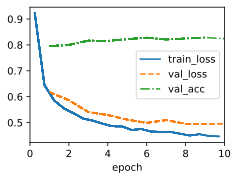

In [11]:
"""
Training:
1. Tạo tập dữ liệu với batch = 256 mẫu
2. Tạo model với số input là tổng số điểm ảnh 1 ảnh, output là số class dự đoán, lr)
3. Khởi tạo trainer với max_epochs = 10
4. Fit model với data đã tạo
"""
data = d2l.FashionMNIST(batch_size = 256) 
model = SoftmaxRegressionScratch(num_inputs = 784, num_outputs = 10, lr = 0.1)
trainer = d2l.Trainer(max_epochs = 10)
trainer.fit(model, data)

#4.4.5. Prediction

Bây giờ, ta sẽ thử dữ đoán, phân loại 1 số hình ảnh.

In [12]:
X, y = next(iter(data.val_dataloader())) # Chọn ra môt batch ngẫu nhiên trong tập val
preds = model(X).argmax(axis = 1)        # Lấy các xác suất cao nhất lưu vào biến preds
preds.shape

torch.Size([256])

Chúng ta sẽ xem thử các nhãn bị gán sai. Ta sẽ hình dung chúng bằng cách so sánh các nhãn thật của chúng với nhãn dự đoán của mô hình

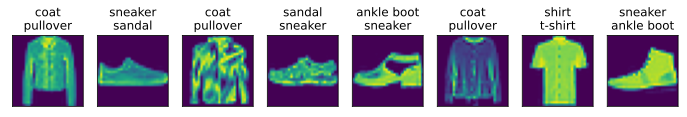

In [13]:
"""
Xem thử các nhãn predict sai với nhãn thật
"""
wrong = preds.type(y.dtype) != y 
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)